<a href="https://colab.research.google.com/github/unachankz/goto_data_science/blob/master/notebook/ImageSuperRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
import torchvision.transforms.functional as F_t
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url

In [2]:
import matplotlib.pyplot as plt
from IPython import display

## Network

In [3]:
class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super().__init__()
        B = torch.randn(in_features, out_features)*scale
        self.register_buffer("B", B)
    
    def forward(self, x):
        x_proj = torch.matmul(2*math.pi*x, self.B)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

In [5]:
class SignalRegressor(nn.Module):
    def __init__(self, in_features, fourier_features,
                 hidden_features, hidden_layers, out_features, scale):
        super().__init__()

        self.net = []
        if fourier_features is not None:
            self.net.append(FourierLayer(in_features, fourier_features, scale))
            self.net.append(nn.Linear(2*fourier_features, hidden_features))
            self.net.append(nn.ReLU())
        else:
            self.net.append(nn.Linear(in_features, hidden_features))
            self.net.append(nn.ReLU())
        
        for i in range(hidden_layers-1):
            self.net.append(nn.Linear(hidden_features, hidden_features))
            self.net.append(nn.ReLU())

        self.net.append(nn.Linear(hidden_features, out_features))
        self.net.append(nn.Sigmoid())
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        out = self.net(x)
        return out

## Dataset

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_path):
        super().__init__()
        self.image_path = image_path

    def __getitem__(self, idx):
        image = read_image(self.image_path)
        image = F_t.convert_image_dtype(image, dtype=torch.float)
        image = image.permute(1, 2, 0)

        h_axis = torch.linspace(0, 1, steps=image.shape[0])
        w_axis = torch.linspace(0, 1, steps=image.shape[1])
        grid = torch.stack(torch.meshgrid(h_axis, w_axis), dim=-1)

        return grid, image
    
    def __len__(self):
        return 1

## Display Image

In [8]:
web_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Lego_Color_Bricks.jpg/320px-Lego_Color_Bricks.jpg"
download_url(web_url, ".", "lego.jpg")

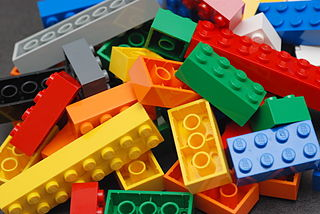

In [9]:
image_path = "lego.jpg"
display.Image(image_path)

## Dataloader

In [11]:
image_data = ImageDataset(image_path)
image_loader = DataLoader(image_data, batch_size=1)

## Super-Resolution
increase image resoltion by 2x

Step: 100, Test PSNR: 12.957409


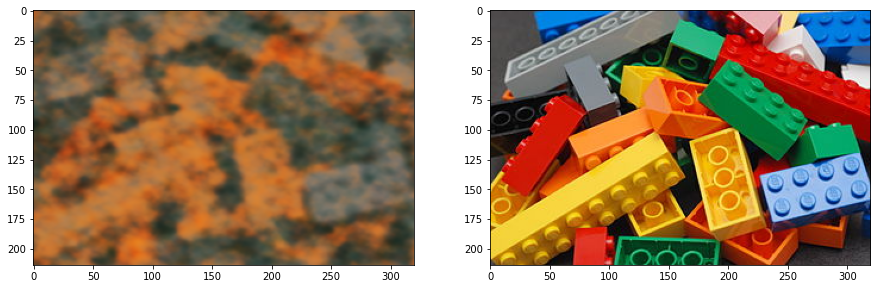

Step: 200, Test PSNR: 20.532452


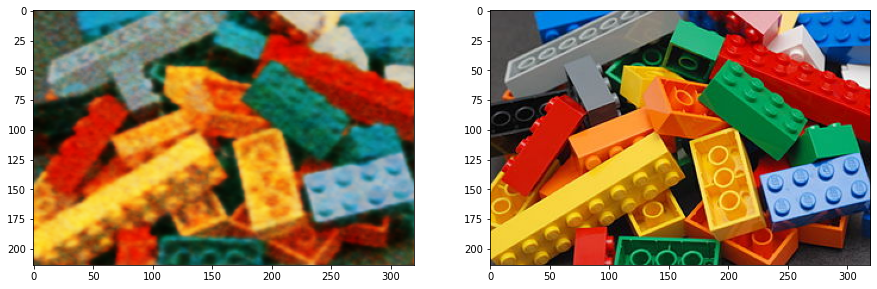

Step: 300, Test PSNR: 24.123098


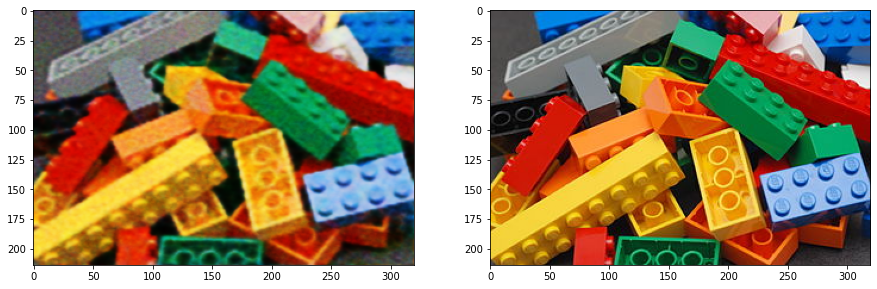

Step: 400, Test PSNR: 25.427637


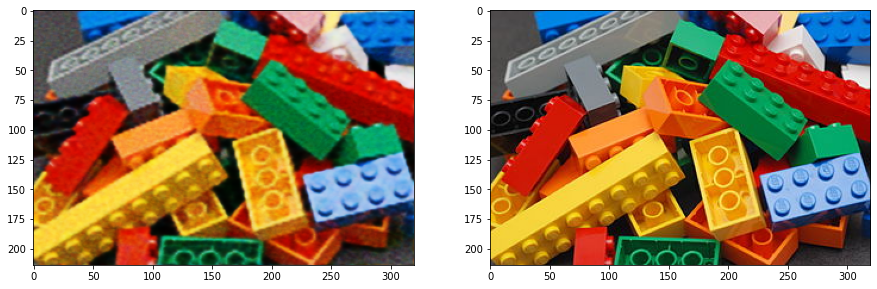

Step: 500, Test PSNR: 26.039064


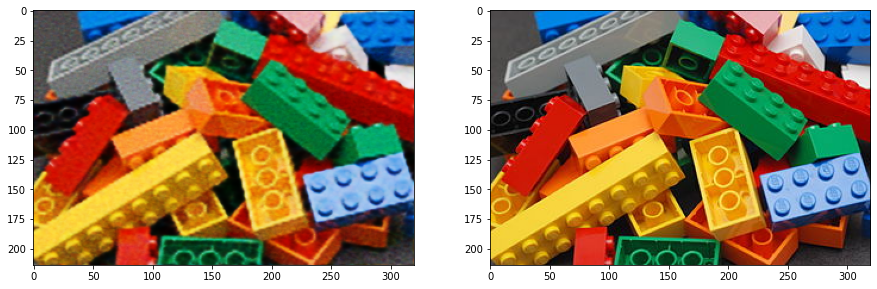

Step: 600, Test PSNR: 26.331627


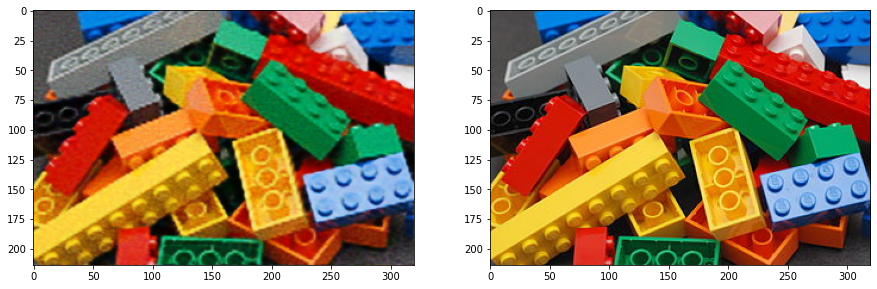

Step: 700, Test PSNR: 26.476259


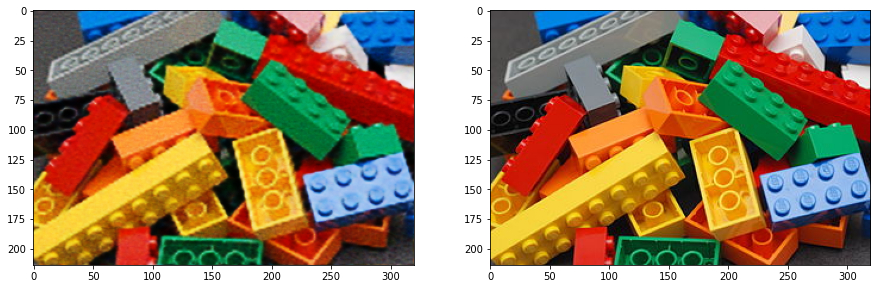

Step: 800, Test PSNR: 26.558315


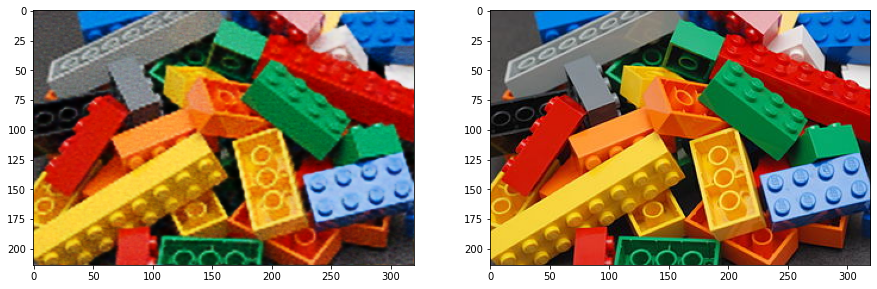

Step: 900, Test PSNR: 26.603561


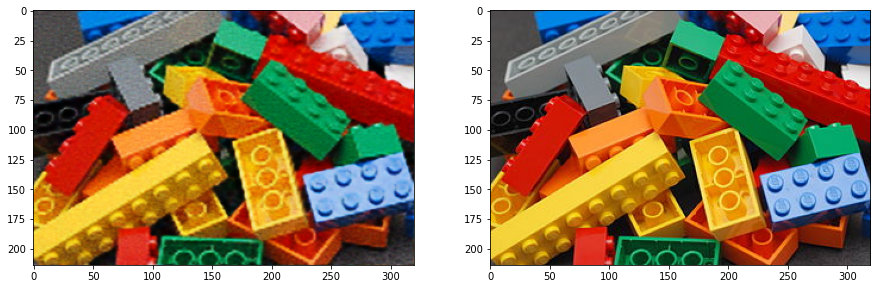

Step: 1000, Test PSNR: 26.625669


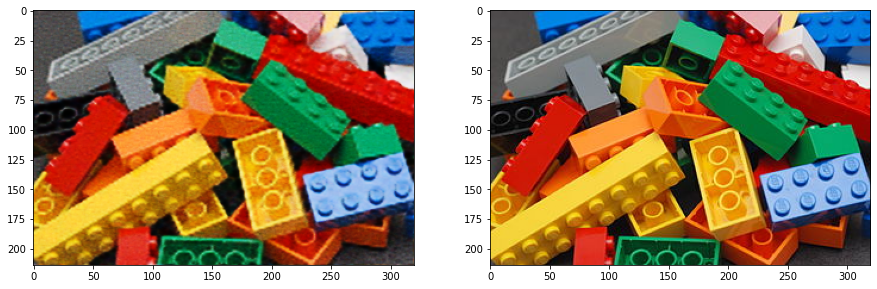

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_steps = 1000
summary_interval = 100

grid, image = next(iter(image_loader))
grid, image = grid.squeeze().to(device), image.squeeze().to(device)
train_coords, train_rgbs = grid[::2, ::2].reshape(-1, 2), image[::2, ::2].reshape(-1, 3)  # use every other pixel for training
test_coords, test_rgbs = grid.reshape(-1, 2), image.reshape(-1, 3)  # use all the pixels for evaluation

image_regressor = SignalRegressor(in_features=2, fourier_features=256,
                                  hidden_features=256, hidden_layers=4, out_features=3, scale=10).to(device)
optim = torch.optim.Adam(lr=1e-4, params=image_regressor.parameters())

for step in range(1, total_steps+1):
    image_regressor.train()
    optim.zero_grad()
    output = image_regressor(train_coords)
    train_loss = F.mse_loss(output, train_rgbs)
    train_loss.backward()
    optim.step()

    if not step % summary_interval:
        image_regressor.eval()
        with torch.no_grad():
            prediction = image_regressor(test_coords)
            test_loss = F.mse_loss(prediction, test_rgbs)
            test_psnr = -10*torch.log10(test_loss)

            print(f"Step: {step}, Test PSNR: {test_psnr.item():.6f}")
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            axes[0].imshow(prediction.reshape_as(image).cpu())
            axes[1].imshow(image.cpu())
            plt.show()